# 🧠 Support Vector Machine (SVM) — Overview
## ✨ What this notebook covers
- Intuition & geometry of SVMs  
- Mathematical formulation (hard-margin, soft-margin) with equations  
- Kernels: why and how they work  
- Visual examples & decision-boundary plots  
- `scikit-learn` usage (linear + kernel SVM) ✅  
- From-scratch linear SVM (primal hinge-loss + GD) ✅  
- Multiclass strategies, tips, and common pitfalls

> **Goal:** step-by-step explanation + runnable code cells you can paste directly into a Jupyter notebook. Let's go! 🚀


In [2]:
# Imports & plotting defaults
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
np.random.seed(0)


## 📐 Intuition: what is an SVM? (Large-font heading for emphasis)
SVM finds a decision boundary (hyperplane) that maximizes the **margin** — the distance from the hyperplane to the nearest training points of any class (those nearest points are called **support vectors**).

**Key idea (mathematically)**  
For linear SVM we look for a weight vector \( \mathbf{w} \) and bias \( b \) such that the hyperplane \( \mathbf{w}^\top \mathbf{x} + b = 0 \) separates data with maximum margin.

**Margin** = \( \dfrac{2}{\|\mathbf{w}\|} \).  
Maximizing margin ⟺ minimizing \( \|\mathbf{w}\| \) subject to correct classification constraints.


## 🧮 Hard-margin SVM: primal formulation (math)
For perfectly linearly separable data, the optimization is:

$$
\begin{aligned}
& \min_{\mathbf{w},b} \quad \frac{1}{2}\|\mathbf{w}\|^2 \\
& \text{subject to} \quad y_i(\mathbf{w}^\top \mathbf{x}_i + b) \ge 1,\quad \forall i
\end{aligned}
$$

This enforces that each point is on the correct side with distance at least $1/\|\mathbf{w}\|$.


## 🧰 Soft-margin SVM: allow misclassifications (math)
When data is not separable we introduce slack variables $ \xi_i \ge 0 $:

$$
\begin{aligned}
& \min_{\mathbf{w},b,\xi} \quad \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{i}\xi_i \\
& \text{subject to} \quad y_i(\mathbf{w}^\top \mathbf{x}_i + b) \ge 1 - \xi_i,\quad \xi_i \ge 0
\end{aligned}
$$

- $C$ balances margin size vs training error. Large $C$ → penalize violations heavily (less regularization).


## 🔁 Hinge loss (primal unconstrained form)
Equivalent (for optimization via gradient methods) is minimizing hinge loss:

$$
\min_{\mathbf{w},b}\; \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i} \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))
$$

The hinge term $\max(0, 1 - y f(\mathbf{x}))$ penalizes points inside or on the wrong side of margin.


## 🧩 Why kernels?
- Linear SVMs separate by a linear hyperplane.
- If data isn't linearly separable in input space, transform it with $ \phi(\mathbf{x}) $ and run SVM in that feature space.
- Kernel trick: compute $K(\mathbf{x}_i,\mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle$ directly without explicit $\phi$.
- Common kernels: Linear, Polynomial, RBF (Gaussian), Sigmoid.

RBF kernel: $ K(x, x') = \exp(-\gamma \|x-x'\|^2) $.


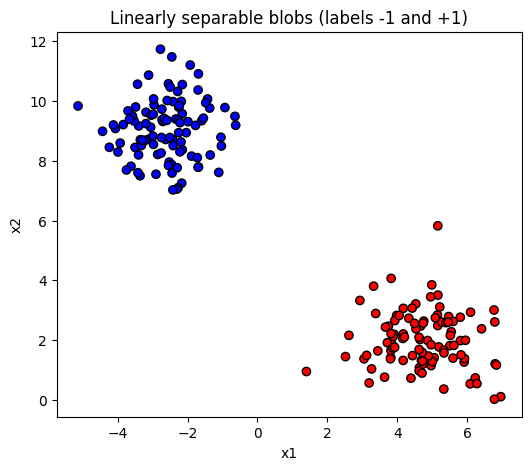

In [3]:
# Create simple 2D dataset (linearly separable) & visualize
X_lin, y_lin = make_blobs(n_samples=200, centers=2, cluster_std=1.0, random_state=42)
y_lin = np.where(y_lin == 0, -1, 1)  # convert labels to -1 / +1 for math consistency
plt.figure(figsize=(6,5))
plt.scatter(X_lin[:,0], X_lin[:,1], c=y_lin, cmap='bwr', edgecolor='k')
plt.title('Linearly separable blobs (labels -1 and +1)')
plt.xlabel('x1'); plt.ylabel('x2')
plt.show()


## 🔍 Visualizing SVM decision boundary (function)
We'll use this helper in multiple cells to plot decision boundaries for a model.


In [4]:
def plot_decision_boundary(model, X, y, title='Decision boundary', plot_support=True):
    # mesh
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,500), np.linspace(y_min,y_max,500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    try:
        Z = model.decision_function(grid)
    except Exception:
        Z = model.predict_proba(grid)[:,1]  # fallback
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, np.sign(Z), alpha=0.1, levels=[-2,0,2], cmap='bwr')
    plt.contour(xx, yy, Z, levels=[-1.0, 0.0, 1.0], linestyles=['--','-','--'], colors='k')
    plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k')
    if plot_support and hasattr(model, "support_"):
        sv = X[model.support_.astype(int)]
        plt.scatter(sv[:,0], sv[:,1], s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='support vectors')
        plt.legend()
    plt.title(title)
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.show()


Train accuracy: 1.0
Test accuracy: 1.0


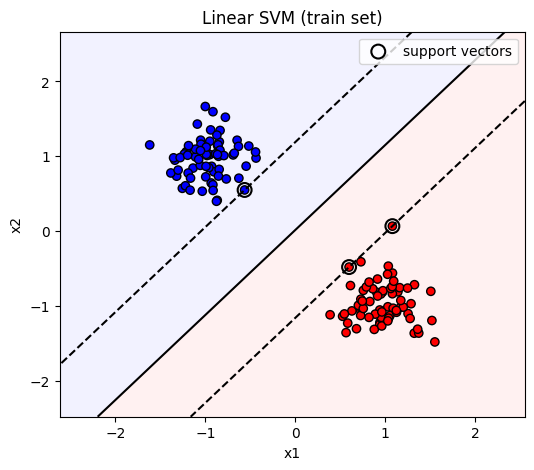

In [5]:
# Train a linear SVM (sklearn) on the linear dataset
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.3, random_state=1)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

svc_lin = SVC(kernel='linear', C=1.0)
svc_lin.fit(X_train_s, y_train)
print("Train accuracy:", svc_lin.score(X_train_s, y_train))
print("Test accuracy:", svc_lin.score(X_test_s, y_test))

# plot decision boundary on scaled data (but scatter using original X to keep axes interpretable)
plot_decision_boundary(svc_lin, X_train_s, y_train, title='Linear SVM (train set)')


## ✅ Observations from linear SVM
- Support vectors are the points touching (or within) the margin.
- Changing `C`:
  - large `C` → narrower margin, fewer misclassifications on training set (risk overfitting).
  - small `C` → wider margin, more regularization (risk underfitting).


In [6]:
# Demonstrate effect of C
for C in [0.01, 0.1, 1, 10, 100]:
    model = SVC(kernel='linear', C=C).fit(X_train_s, y_train)
    acc = model.score(X_test_s, y_test)
    print(f"C={C:>6}  test accuracy={acc:.3f}  support_vectors={model.support_.shape[0]}")


C=  0.01  test accuracy=1.000  support_vectors=66
C=   0.1  test accuracy=1.000  support_vectors=12
C=     1  test accuracy=1.000  support_vectors=3
C=    10  test accuracy=1.000  support_vectors=3
C=   100  test accuracy=1.000  support_vectors=3


## 🔁 Kernel SVM example: non-linearly separable data (circles)
We'll generate concentric circles that require a nonlinear boundary (RBF works well).


RBF SVM test acc: 1.0


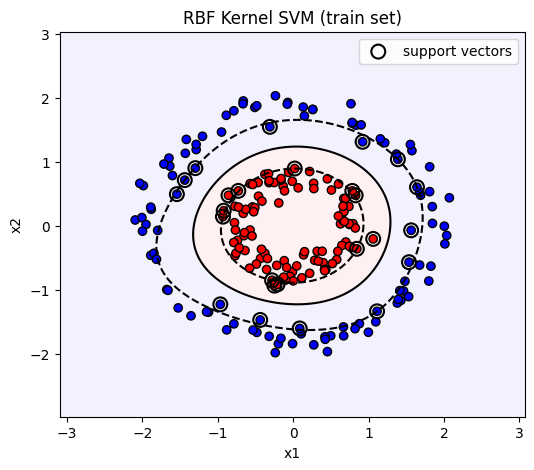

In [7]:
X_circ, y_circ = make_circles(n_samples=300, factor=0.4, noise=0.07, random_state=0)
y_circ = np.where(y_circ==0, -1, 1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_circ, y_circ, test_size=0.3, random_state=2)
scaler2 = StandardScaler()
X_train2_s = scaler2.fit_transform(X_train2)
X_test2_s = scaler2.transform(X_test2)

svc_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svc_rbf.fit(X_train2_s, y_train2)
print("RBF SVM test acc:", svc_rbf.score(X_test2_s, y_test2))
plot_decision_boundary(svc_rbf, X_train2_s, y_train2, title='RBF Kernel SVM (train set)')


## 🛠️ From-scratch: Linear SVM via Primal Hinge Loss + Gradient Descent
We'll implement a simple (not highly optimized) linear SVM by minimizing:

$$
\frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i}\max(0, 1 - y_i(\mathbf{w}^\top x_i + b))
$$

- We'll use batch gradient descent.
- This implementation is educational — not as fast/robust as `libsvm` used by `scikit-learn`.


In [8]:
# From-scratch linear SVM (primal hinge loss) implementation
class LinearSVMFromScratch:
    def __init__(self, C=1.0, lr=0.01, n_iter=1000, verbose=False):
        self.C = C
        self.lr = lr
        self.n_iter = n_iter
        self.verbose = verbose

    def fit(self, X, y):
        # X: (n_samples, n_features), y: {-1,1}
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        for it in range(self.n_iter):
            # compute margin errors
            margins = y * (X.dot(self.w) + self.b)
            # indicator for hinge loss > 0 or not
            mis_idx = margins < 1
            # gradient of 1/2||w||^2 is w
            grad_w = self.w.copy()
            grad_b = 0.0
            if np.any(mis_idx):
                # hinge gradient part: -C * sum_{mis} y_i x_i
                grad_w -= self.C * np.sum(y[mis_idx, None] * X[mis_idx], axis=0)
                grad_b -= self.C * np.sum(y[mis_idx])
            # update
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            if self.verbose and it % (self.n_iter//5 or 1) == 0:
                # compute objective approx
                hinge = np.maximum(0, 1 - margins)
                obj = 0.5 * np.dot(self.w, self.w) + self.C * np.sum(hinge)
                print(f"iter {it}, obj {obj:.4f}")

    def decision_function(self, X):
        return X.dot(self.w) + self.b

    def predict(self, X):
        return np.where(self.decision_function(X) >= 0, 1, -1)


From-scratch test accuracy: 1.0
sklearn LinearSVC test accuracy: 1.0


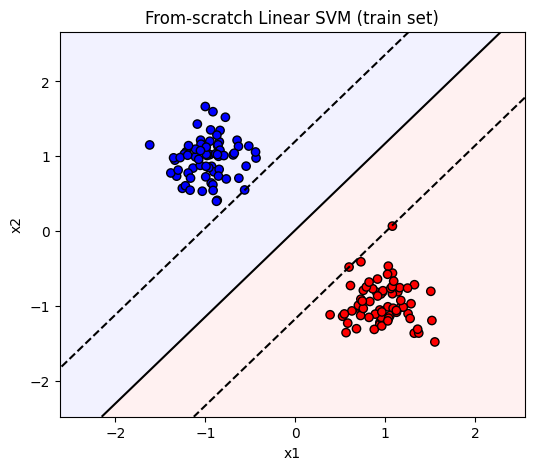

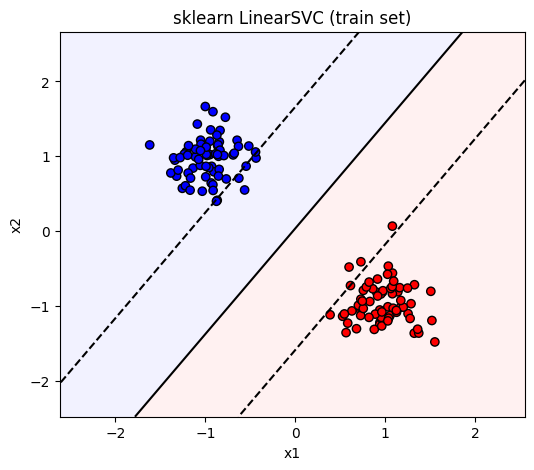

In [9]:
# Train & compare with sklearn linear SVM
svm_scratch = LinearSVMFromScratch(C=1.0, lr=0.01, n_iter=2000, verbose=False)
svm_scratch.fit(X_train_s, y_train)
y_pred_scratch = svm_scratch.predict(X_test_s)
print("From-scratch test accuracy:", accuracy_score(y_test, y_pred_scratch))

# Compare to sklearn LinearSVC
linear_svc = LinearSVC(C=1.0, max_iter=5000, dual=False)  # use primal for better comparison on many features
linear_svc.fit(X_train_s, y_train)
print("sklearn LinearSVC test accuracy:", linear_svc.score(X_test_s, y_test))

# Plot decision boundaries (use unscaled plotting axes by plotting scaled data)
plot_decision_boundary(svm_scratch, X_train_s, y_train, title='From-scratch Linear SVM (train set)', plot_support=False)
plot_decision_boundary(linear_svc, X_train_s, y_train, title='sklearn LinearSVC (train set)')


## 🔁 Multiclass with SVMs
- `SVM` is inherently binary.
- Common strategies for multiclass:
  - One-vs-Rest (OvR) — train one classifier per class vs all others.
  - One-vs-One (OvO) — train classifier for every pair of classes.
- `scikit-learn` SVC uses OvO by default; `LinearSVC` uses OvR by default. You can override with `decision_function_shape='ovr'` or `ovo`.


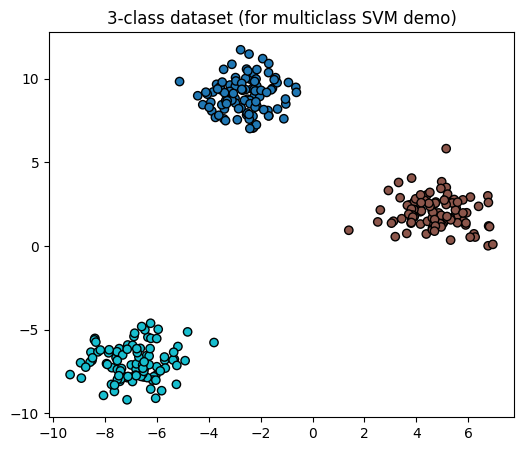

In [10]:
# Quick multiclass demo using blobs (3 classes) and sklearn SVC
X3, y3 = make_blobs(n_samples=300, centers=3, random_state=42)
svc_multi = SVC(kernel='rbf', C=1.0).fit(X3, y3)
plt.figure(figsize=(6,5))
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap='tab10', edgecolor='k')
plt.title('3-class dataset (for multiclass SVM demo)')
plt.show()


## 🧾 Tips, common pitfalls & hyperparameter tuning
- Always **scale your features** for SVMs (especially for RBF kernel). `StandardScaler` is common.
- `C` controls regularization; try log-spaced values (e.g., `10**np.linspace(-3,3,7)`).
- `gamma` (for RBF/polynomial kernels) affects shape of decision boundary — small gamma = smooth decision boundary; large gamma = more complex.
- For large datasets, linear SVM via `LinearSVC` or `SGDClassifier(loss='hinge')` is faster than `SVC(kernel='rbf')`.
- Visualize support vectors to understand model capacity and sensitivity.


## 📌 Summary & next steps
- You now have:
  - Math derivation (hard & soft margin) and hinge loss form.
  - Visual intuition and code to plot decision boundaries.
  - `scikit-learn` examples for linear and kernel SVMs.
  - A from-scratch linear SVM (primal hinge + GD) for learning.
- **Next suggestions:** experiment with `C`, `gamma`, different kernels, and larger synthetic or real datasets (e.g., MNIST — use linear SVM or kernel approximations). If you want, I can:
  - add cross-validation & grid search examples, or
  - implement SMO algorithm from scratch for the dual SVM, or
  - show SVM on a real dataset (with full preprocessing and report).
